# Fruit Inspection - Exercise 2

## Importing the needed libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
print(os.getcwd())

C:\Users\aleda\Documents\GitHub\FruitDefectsInspection


## Tools

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def plot_images_row(imgs, title = ""):

  imgs_dim = [img.shape for img in imgs]
  max_rows = max([img_dim[0] for img_dim in imgs_dim])
  max_cols = max([img_dim[1] for img_dim in imgs_dim])
  
  cropped_imgs = []
  for i in imgs:
   cropped_imgs.append(cv2.copyMakeBorder(i,0, max_rows-i.shape[0], 0, max_cols - i.shape[1],cv2.BORDER_REPLICATE))

  fig = plt.figure(1, (14, 5))
  fig.suptitle(title, fontsize=16)
  grid = ImageGrid(fig, 111, # similar to subplot(111)
                  nrows_ncols = (1, len(imgs)), # creates 2x2 grid of axes
                  axes_pad=0.1, # pad between axes in inch.
                  )

  for i in range(len(imgs)):
      grid[i].imshow(cropped_imgs[i], cmap='gray') # The AxesGrid object work as a list of axes.

  plt.show()


def show_masking_effect(binary_mask, color_image, show_output=False, transparency=0.7):
    background = color_image
    overlay = np.stack([ binary_mask, np.zeros(binary_mask.shape, dtype=np.uint8), np.zeros(binary_mask.shape,np.uint8)], axis=2)
    added_image = cv2.addWeighted(background,0.9,overlay,transparency,0)

    if show_output:
        plt.imshow(added_image, cmap="gray")
        plt.title("Image + binary mask overlay")
        plt.show()
    
    return added_image 

## Importing the images

### Black and white images

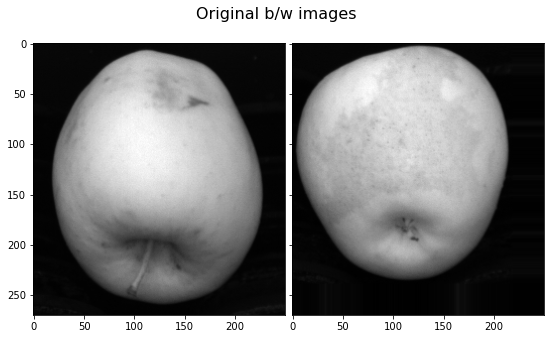

In [3]:
imgs = [cv2.imread(f"./second task/src/C0_00000{i}.png",cv2.IMREAD_GRAYSCALE) for i in range (4,6)]
plot_images_row(imgs, title = "Original b/w images")

### Color images

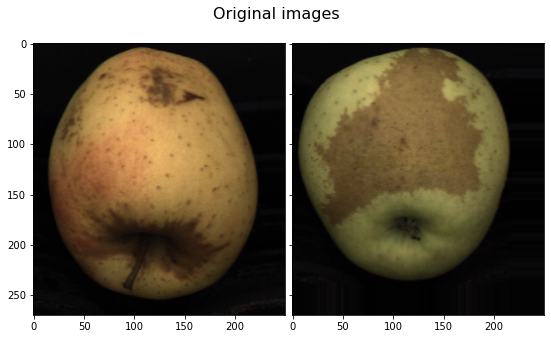

In [4]:
color_imgs = [cv2.imread(f"./second task/src/C1_00000{i}.png") for i in range (4,6)]
color_imgs = [cv2.cvtColor(i,cv2.COLOR_BGR2RGB) for i in color_imgs]
plot_images_row(color_imgs, title = "Original images")

### Checking parallax

Checking if the sizes of b/w images and color images correctly match
[(270, 250), (240, 220)]
[(270, 250, 3), (240, 220, 3)]



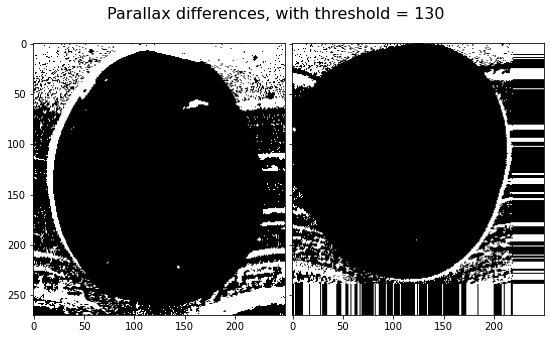

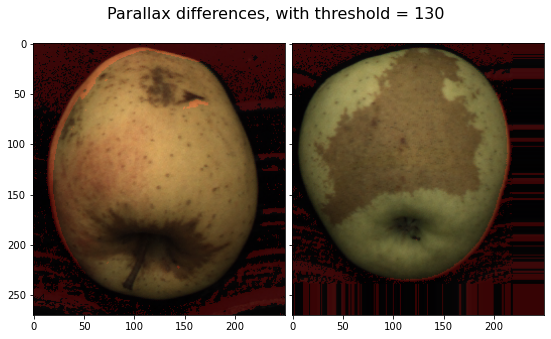

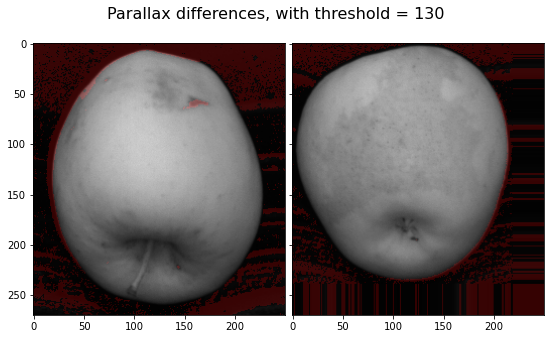

In [5]:
print("Checking if the sizes of b/w images and color images correctly match")
print([i.shape for i in imgs])
print([i.shape for i in color_imgs])
print()

parallax_difference = [np.array(abs(imgs[i] - cv2.cvtColor(color_imgs[i], cv2.COLOR_RGB2GRAY))) for i in range(len(imgs))]
thresh = 130
parallax_mask = [(parallax_difference[i]>thresh).astype(np.uint8)*255 for i in range(len(imgs))]
plot_images_row(parallax_mask, title = f"Parallax differences, with threshold = {thresh}")

overlay_parallax_color = [show_masking_effect(parallax_mask[i], color_imgs[i], transparency=0.2) for i in range(len(imgs))]
overlay_parallax_bw = [show_masking_effect(parallax_mask[i], cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2RGB), transparency=0.2) for i in range(len(imgs))]
plot_images_row(overlay_parallax_color, title = f"Parallax differences, with threshold = {thresh}")
plot_images_row(overlay_parallax_bw, title = f"Parallax differences, with threshold = {thresh}")

We can easily see that there's more parallax, if we compare this set to the one given in ex-1. It is not possible to apply a mask computed on the b/w image on the color image, because some regions of the apple would be cut down and, therefore, not analyzed.

## Background / foreground segmentation

Since computing a mask on the b/w images and later apply it to the color image is not an option (as stated in the previous subsection) the color images are converted in grayscale and then a thresholding strategy is applied(it is the same one already explained in ex1 with the use of a custom function as point operator, otsu, morphing and flood filling).

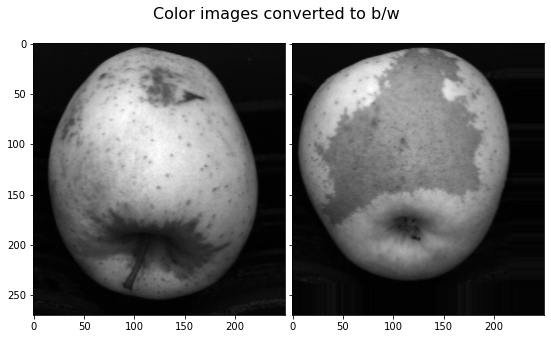

In [6]:
color_grayed_images = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in color_imgs]

plot_images_row(color_grayed_images, title = f"Color images converted to b/w")

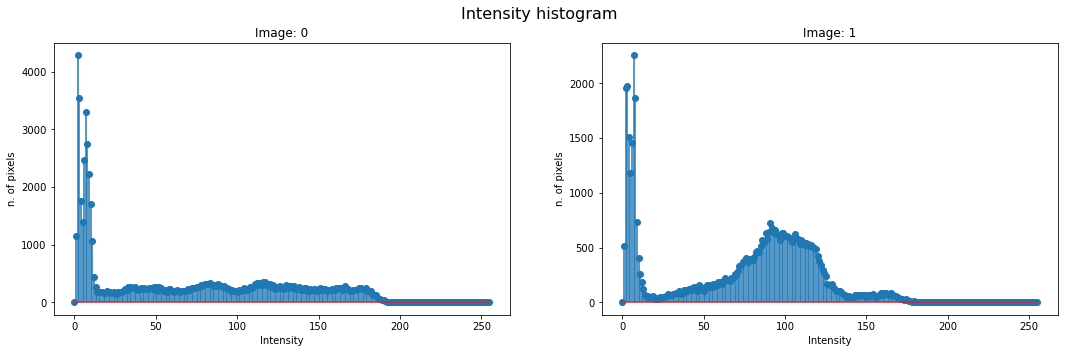

In [7]:
def plot_intensity_hists(hists, fig_size=(18,5),thresh=None):

    fig, axs = plt.subplots(1, len(hists))
    fig.set_size_inches(fig_size[0], fig_size[1])
    fig.suptitle("Intensity histogram", fontsize=16)

    for i in range(len(hists)):
        axs[i].stem(hists[i],use_line_collection=True) # The AxesGrid object work as a list of axes.
        axs[i].set_title(f"Image: {i}")
        if thresh:
          axs[i].axvline(thresh, color='r', label="manual threshold")
          axs[i].legend()
        axs[i].set_xlabel("Intensity")
        axs[i].set_ylabel("n. of pixels")
    plt.show()


hists = [ np.histogram(i.flatten(), 256, [0,256])[0] for i in color_grayed_images]
plot_intensity_hists(hists)

From these histograms it is clear that while the second image has two well defined peaks (so, it's clearly bimodal), the first image has a first peak in the dark regions but a more uniform distribution on the rest of the intensities, in which the other high peak is not clearly detectable. We'll try to solve this last problem with the used of the ```displacement``` attribute of the custom point operator function.

In [8]:
def gammaFunction(r, displacement=0):
    table = [((max(i+displacement,0) / 255) ** r) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return table


def sigmoidHillFunction(displacement):
    table = [1/(1+np.e**(-(i-11)))*256 for i in np.linspace(0,10,  displacement + 1)]
    return table


def customFunction(displacement = -28):
    r = 1/8
    table = gammaFunction(r,displacement)
    sigmoid = sigmoidHillFunction(-displacement)
    table = np.array([sigmoid[i] if i<=(-displacement) else table[i] for i in range(len(table))], np.uint8)
    return table


def customFunctionCorrection(img, displacement=-28):
    table = customFunction(displacement)
    return cv2.LUT(img, table)


def customFunctionOtsu(img, displacement=-28):
    filtered_img = customFunctionCorrection(img, displacement)
    th_value,th = cv2.threshold(filtered_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th

def customFunctionOtsuMorph2(img, show_output=False, displacement=-21):
    '''
    In this implementation (tuned for exercise 2), Custom function + OTSU is applied,
    Morph Transformations (closing with a 5x5 circle, opening with a 4x4 square) following it


    img: The image to apply Custom function + OTSU + Morph Transformations (Opening+Closing) on
    show_output: True if the obtained image has to be printed
    '''
    custom_otsu_mask = customFunctionOtsu(img, displacement)
    
    kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    kernel_opening = np.ones((6,6))

    morphed_mask = cv2.morphologyEx(custom_otsu_mask, cv2.MORPH_CLOSE, kernel_opening)
    morphed_mask = cv2.morphologyEx(morphed_mask, cv2.MORPH_OPEN, kernel_closing)

    if show_output:
        plt.imshow(morphed_mask, cmap="gray")
        plt.title("Custom Function Point Operator + OTSU + Morph")
        plt.show()

    return morphed_mask

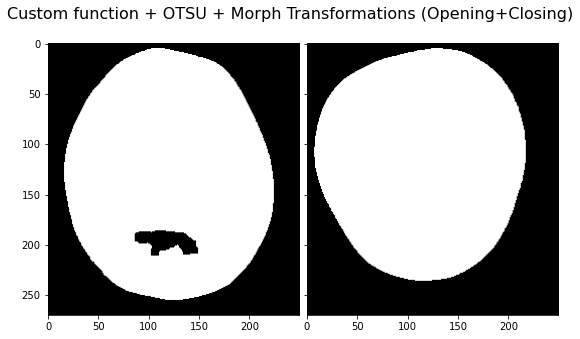

In [9]:
custom_otsu_masks = [customFunctionOtsuMorph2(i,displacement=-23) for i in color_grayed_images]

plot_images_row(custom_otsu_masks, title = "Custom function + OTSU + Morph Transformations (Opening+Closing)")

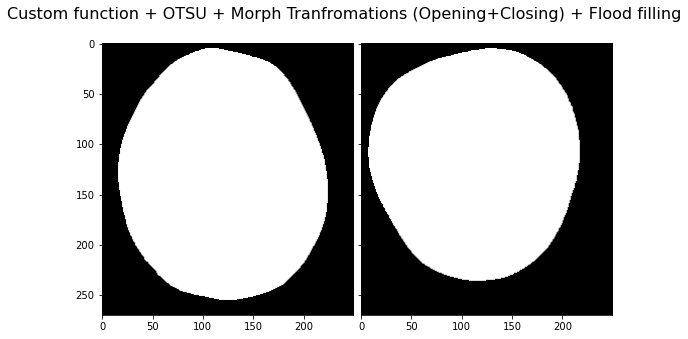

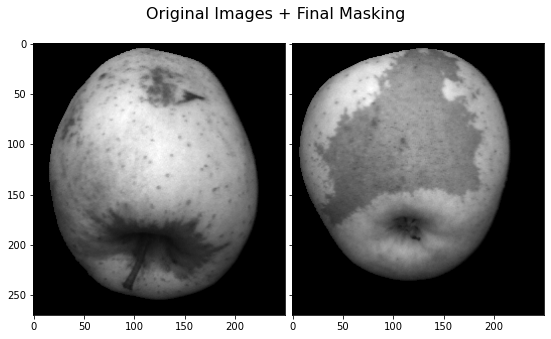

In [10]:
def floodFillBackground(src_image, show_output=False):

    image = src_image.copy()
    image_inverse = cv2.bitwise_not(image)

    h, w = image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    canvas = np.zeros((h + 2, w + 2), np.uint8)

    # Flood filling blackground with black pixels starting from left up corner
    cv2.floodFill(image_inverse,mask, (0, 0), 0)

    im_out = image_inverse | image

    if show_output:
        plt.imshow(im_out, cmap="gray")
        plt.title("Flood filled background")
        plt.show()

    return im_out


floodFilledImages = [floodFillBackground(i) for i in custom_otsu_masks]

plot_images_row(floodFilledImages, title = "Custom function + OTSU + Morph Tranfromations (Opening+Closing) + Flood filling")

masked_images = [cv2.bitwise_and(color_grayed_images[i],floodFilledImages[i]) for i in range(len(color_grayed_images))]

plot_images_row(masked_images, title = "Original Images + Final Masking")

## Color-based segmentation

Color-segmentation is tried using the following color spaces:

*   **RGB**: The most commonly used color space in computer vision technology is the RGB color space because it deals directly with the red, green, and blue channels that are closely associated with the human visual system.
*   **HLS** and **HSV**: The HLS and HSV models, for instance, instead of representing colors as superpositions of three primary colors, have values for the hue of the color, the degree of saturation, and the intensity. 
*   **LAB**: The Lab color space is quite different from the RGB color space. In RGB color space the color information is separated into three channels but the same three channels also encode brightness information. On the other hand, in Lab color space, the L channel is independent of color information and encodes brightness only. The other two channels encode color.

#### Visualizing color distribution in the different channels using different color spaces

RGB color space


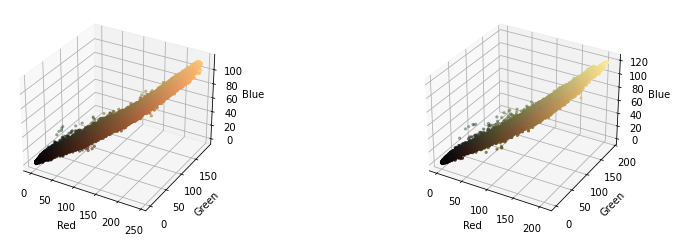

HLS color space


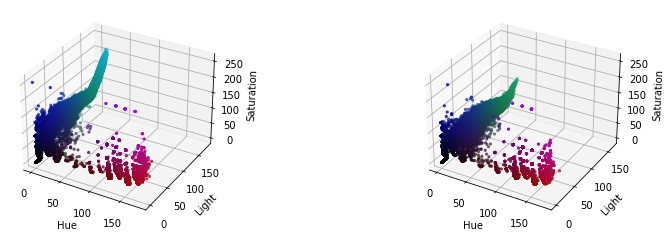

HSV color space


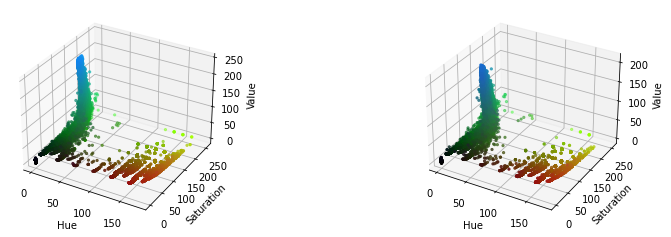

LAB color space


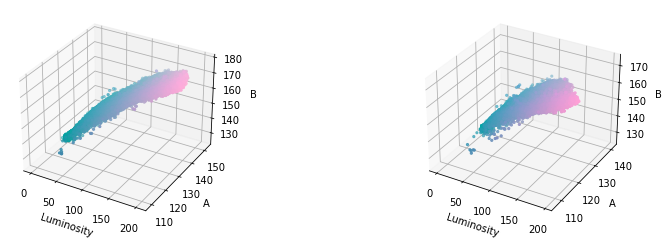

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

def print_color_scatterplot(img, color_names, title):
    
    print(title)
    im = img.copy()

    fig = plt.figure(figsize=plt.figaspect(0.30))
    

    for i in range(len(im)):
        r, g, b = cv2.split(im[i])
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        #axis = grid.add_subplot(1, 1, 1, projection="3d")
        pixel_colors = im[i].reshape((np.shape(im[i])[0]*np.shape(im[i])[1], 3))
        norm = colors.Normalize(vmin=-1.,vmax=1.)
        norm.autoscale(pixel_colors)
        pixel_colors = norm(pixel_colors).tolist()
        ax.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
        ax.set_xlabel(color_names[0])
        ax.set_ylabel(color_names[1])
        ax.set_zlabel(color_names[2])
    
    plt.show()

# RGB
print_color_scatterplot(color_imgs, ["Red", "Green", "Blue"],"RGB color space")
# HLS
hls_color_imgs = [cv2.cvtColor(i,cv2.COLOR_RGB2HLS) for i in color_imgs.copy()]
print_color_scatterplot(hls_color_imgs, ["Hue", "Light", "Saturation"],"HLS color space")
# HSV
lab_color_imgs = [cv2.cvtColor(i,cv2.COLOR_RGB2HSV) for i in color_imgs.copy()]
print_color_scatterplot(lab_color_imgs, ["Hue", "Saturation", "Value"],"HSV color space")
# LAB
lab_color_imgs = [cv2.cvtColor(i,cv2.COLOR_RGB2LAB) for i in color_imgs.copy()]
print_color_scatterplot(lab_color_imgs, ["Luminosity", "A", "B"],"LAB color space")

## Using KMeans to apply color segmentation

In this subsection there's an attempt to apply K-Means to obtain a sufficiently good color-based segementation 

In [12]:
def k_means_labeling(im, K, show_plot=True, title=""):
    img = im.copy()
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    if show_plot:
        plt.imshow(res2)
        plt.title(title)
        plt.show()
    
    return center, res2

def labels2mask(image, labels, labels2extract):
    mask_image = np.zeros((image.shape[0],image.shape[1]))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in labels2extract:
                if (image[i,j] == labels[k]).all():
                    mask_image[i,j] = 255
    return mask_image

### KMeans trial on different color spaces

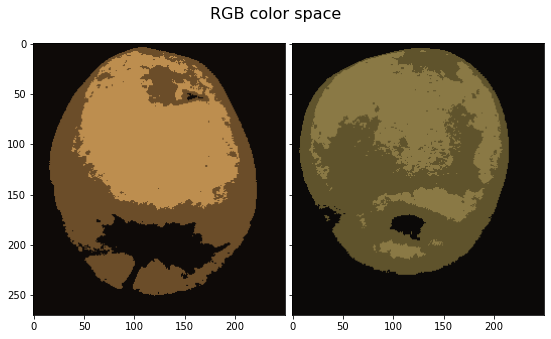

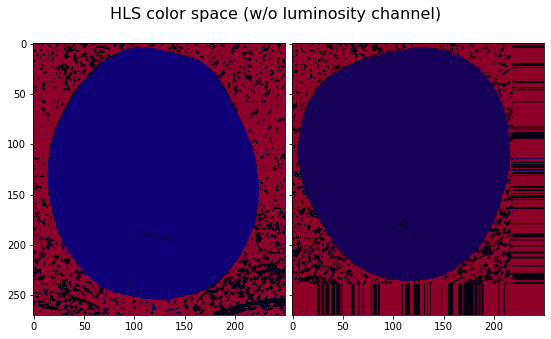

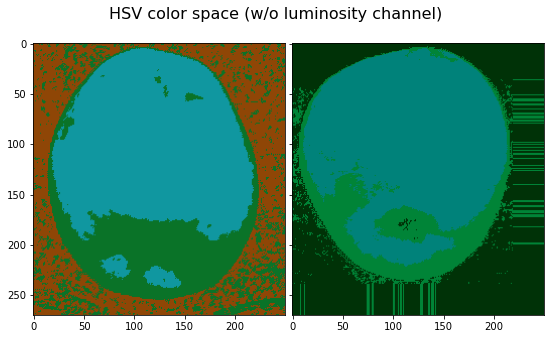

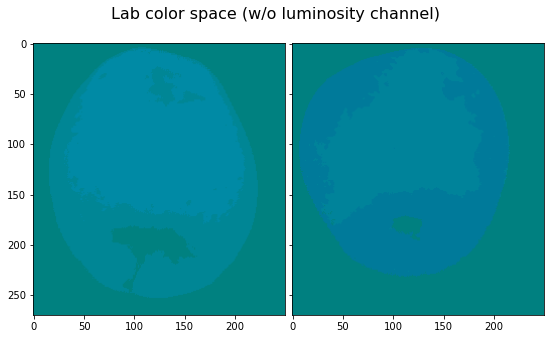

In [13]:
## K-Means on **RGB** colorspace 

# Image 1
first_sample = color_imgs[0].copy()
labels_11, k_means_11 = k_means_labeling(first_sample, K=3, show_plot=False)

# Image 2
second_sample= color_imgs[1].copy()
labels_2, k_means_2 = k_means_labeling(second_sample, K=3,show_plot=False)


plot_images_row([k_means_11,k_means_2], title="RGB color space")

## K-Means on HLS colorspace without luminosity channel (L)

# Image 1
first_sample = color_imgs[0].copy()
first_sample = cv2.cvtColor(first_sample,cv2.COLOR_RGB2HLS)
first_sample[:,:,1] = 0
labels_11, k_means_11 = k_means_labeling(first_sample, K=3, show_plot=False)

# Image 2
second_sample= cv2.cvtColor(color_imgs[1].copy(),cv2.COLOR_RGB2HLS)
second_sample[:,:,1] = 0
labels_2, k_means_2 = k_means_labeling(second_sample, K=3, show_plot=False)

plot_images_row([k_means_11,k_means_2], title="HLS color space (w/o luminosity channel)")

## K-Means on HSV colorspace 

# Image 1
first_sample = color_imgs[0].copy()
first_sample = cv2.cvtColor(first_sample,cv2.COLOR_RGB2HSV)
labels_11, k_means_11 = k_means_labeling(first_sample, K=3, show_plot=False)

# Image 2
second_sample= cv2.cvtColor(color_imgs[1].copy(),cv2.COLOR_RGB2HSV)
second_sample[:,:,0] = 0
labels_2, k_means_2 = k_means_labeling(second_sample, K=3,show_plot=False)

plot_images_row([k_means_11,k_means_2], title="HSV color space (w/o luminosity channel)")

## K-Means on Lab colorspace without luminosity channel (L)

# Image 1
first_sample = color_imgs[0].copy()
first_sample = cv2.cvtColor(first_sample,cv2.COLOR_RGB2Lab)
first_sample[:,:,0] = 0
labels_11, k_means_11 = k_means_labeling(first_sample, K=3, show_plot=False)

# Image 2
second_sample= cv2.cvtColor(color_imgs[1].copy(),cv2.COLOR_RGB2Lab)
second_sample[:,:,0] = 0
labels_2, k_means_2 = k_means_labeling(second_sample, K=3, show_plot=False)

plot_images_row([k_means_11,k_means_2], title="Lab color space (w/o luminosity channel)")

Indeed the result seems artistic and Warholian, but not useful for our purpose: no color space has resulted in being sufficient to highlight all the areas covered by the russet using K-means clustering. The color space which comes closer to the wanted result is the *RGB* colorspace for the 1st image and the *Lab colorspace* for the 2nd image.

## Using Mahalanobis distance

### Manual selection on 1st image

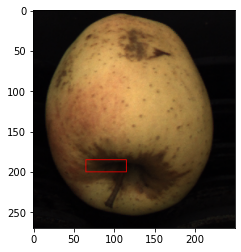

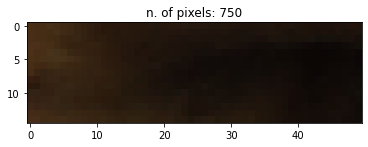

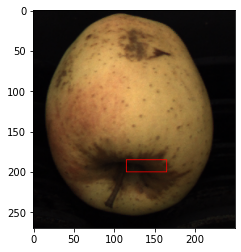

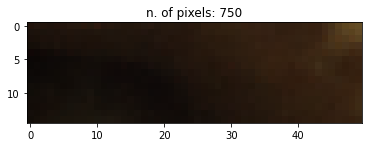

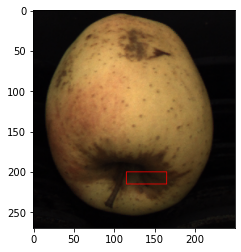

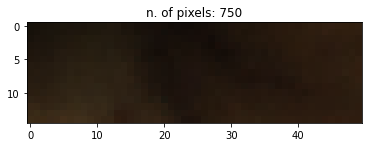

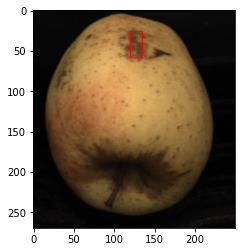

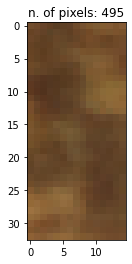

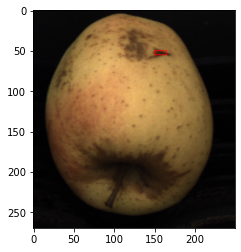

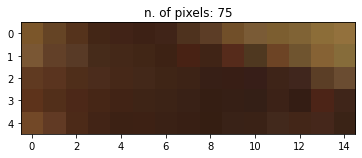

In [14]:
def sample_extract(img, hl, hu, wl, wu, show=True, title=""):
    im = img.copy()
    cut = im[hl:hu,wl:wu]
    if show:
        im_rectangle = im.copy()
        sample_extraction = cv2.rectangle(im_rectangle, (wl,hl), (wu,hu), (255,0,0), 1)
        plt.imshow(sample_extraction, cmap="gray")
        plt.title(title)
        plt.show()
        plt.imshow(cut)
        plt.title(f"n. of pixels: {cut.shape[0]*cut.shape[1]}")
        plt.show()
    
    return cut

first_sample = color_imgs[0].copy()

ROI_1_first_sample = sample_extract(first_sample, 185, 200, 65, 115)

ROI_2_first_sample = sample_extract(first_sample, 185, 200, 115, 165)

ROI_3_first_sample = sample_extract(first_sample, 200, 215, 115, 165)

ROI_4_first_sample = np.rot90(sample_extract(first_sample, 26, 59, 120, 135))

ROI_5_first_sample = np.rot90(sample_extract(first_sample, 50, 55, 150, 165))

### Manual selection on 2nd image

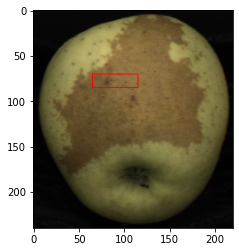

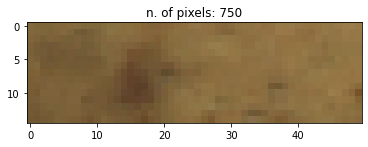

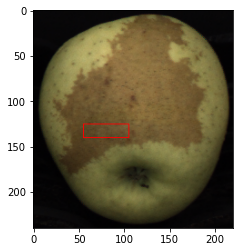

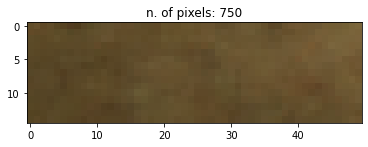

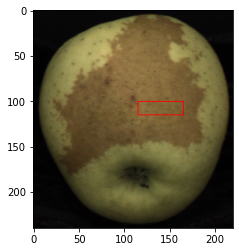

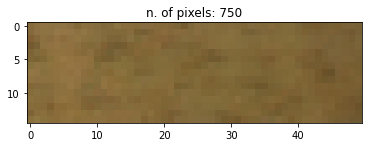

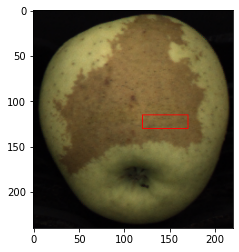

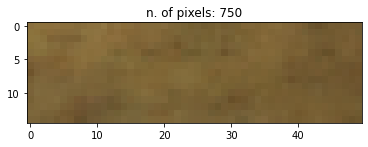

In [15]:
second_sample = color_imgs[1].copy()

ROI_1_second_sample = sample_extract(second_sample, 70, 85, 65, 115)

ROI_2_second_sample = sample_extract(second_sample, 125, 140, 55, 105)

ROI_3_second_sample = sample_extract(second_sample, 100, 115, 115, 165)

ROI_4_second_sample =sample_extract(second_sample, 115, 130, 120, 170)


### Preparing the patches used to later compute the Mahalanobis distance

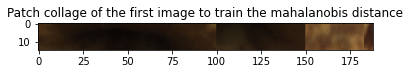

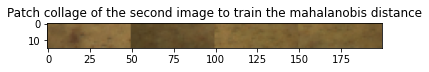

In [16]:
# creating the final patch (1st image) to train the mahalanobis distance
collage_patches_first_sample = np.concatenate((ROI_1_first_sample,ROI_2_first_sample,ROI_3_first_sample,ROI_4_first_sample, ROI_5_first_sample), axis=1)
plt.imshow(collage_patches_first_sample)
plt.title("Patch collage of the first image to train the mahalanobis distance")
plt.show()

# creating the final patch (2nd image) to train the mahalanobis distance
collage_patches_second_sample = np.concatenate((ROI_1_second_sample,ROI_2_second_sample,ROI_3_second_sample,ROI_4_second_sample), axis=1)
plt.imshow(collage_patches_second_sample)
plt.title("Patch collage of the second image to train the mahalanobis distance")
plt.show()

### Defining the functions useful to compute the Mahalanobis distance

In [17]:
def compute_means(img):
    im =img.copy()
    mean=[0,0,0]
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mean += im[i,j]
    
    return mean/(im.shape[0]*im.shape[1])


def compute_cov_matrix_and_mean(img):
    im = img.copy()
    
    mean = compute_means(im)
    cov_matrix = np.zeros((3,3))

    for i in range(0,3):
        for j in range(0,3):
            cov_matrix[i,j] = variance(im, mean[i], mean[j], i,j)

    diagonal,_ = np.linalg.eig(cov_matrix)

    return diagonal, mean


def variance(img, mean_i, mean_j, i, j):
    im = img.copy()

    sum = 0

    for k1 in range(im.shape[0]):
        for k2 in range(im.shape[1]):
            sum += (im[k1,k2][i] - mean_i)*(im[k1,k2][j] - mean_j)

    return sum/(im.shape[0]*im.shape[1])


def mahalanobis(pixel, means, variances, threshold=3):
    sum = 0

    sum += ((pixel[0] - means[0]) **2) / variances[0]
    sum += ((pixel[1] - means[1]) **2) / variances[1]
    sum += ((pixel[2] - means[2]) **2) / variances[2]

    if sum < (threshold**2):
        return 255
    else:
        return 0


def apply_mahalanobis(original_img, training_img, threshold,color_space="rgb"):
    '''
    original_img: the image to be segmented, in RGB color space
    training_img: the set of patches used to train the mahalanobis distance
    threshold: the threshold to use over the mahalanobis distance
    color_space: the color space in which the original_img and training_img are converted
    '''
    if color_space == "hls":
      training_img = cv2.cvtColor(training_img.copy(), cv2.COLOR_RGB2HLS)
      original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2HLS)
    elif color_space == "hsv":
      training_img = cv2.cvtColor(training_img.copy(), cv2.COLOR_RGB2HSV)
      original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2HSV)
    elif color_space == "lab":
      training_img = cv2.cvtColor(training_img.copy(), cv2.COLOR_RGB2Lab)
      original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2Lab)

    mahalanobis_thresholded = np.zeros((original_img.shape[0],original_img.shape[1]), dtype=np.uint8)
    
    variances, means = compute_cov_matrix_and_mean(training_img)

    for i in range(original_img.shape[0]):
        for j in range(original_img.shape[1]):
            mahalanobis_thresholded[i,j] = mahalanobis(original_img[i,j], means, variances,threshold)
    
    return mahalanobis_thresholded, variances, means, threshold


def apply_mahalanobis_precomputed(original_img, variances, means, threshold,color_space="rgb"):
    '''
    original_img: the image to be segmented, in RGB color space
    training_img: the set of patches used to train the mahalanobis distance
    threshold: the threshold to use over the mahalanobis distance
    color_space: the color space in which the original_img and training_img are converted
    '''
    if color_space == "hls":
      original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2HLS)
    elif color_space == "hsv":
      original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2HSV)
    elif color_space == "lab":
      original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2Lab)

    mahalanobis_thresholded = np.zeros((original_img.shape[0],original_img.shape[1]), dtype=np.uint8)

    for i in range(original_img.shape[0]):
        for j in range(original_img.shape[1]):
            mahalanobis_thresholded[i,j] = mahalanobis(original_img[i,j], means, variances,threshold)
    
    return mahalanobis_thresholded, variances, means, threshold

### Segmentation with Mahalanobis distance using different color spaces

#### Mahalanobis trained on the 1st image patches

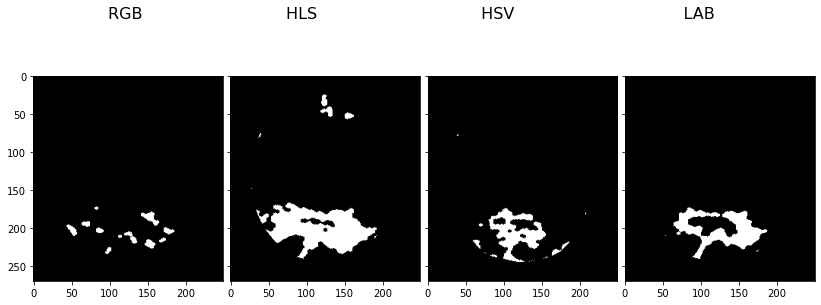

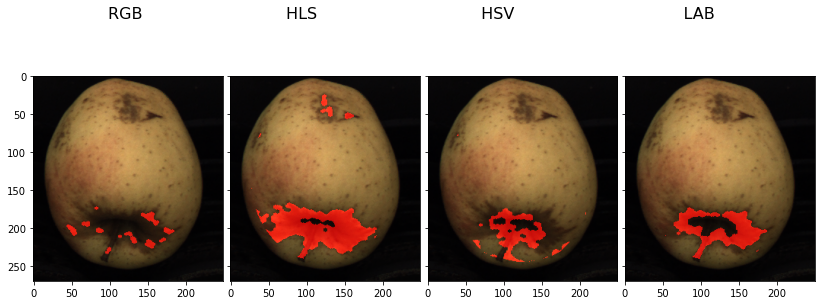

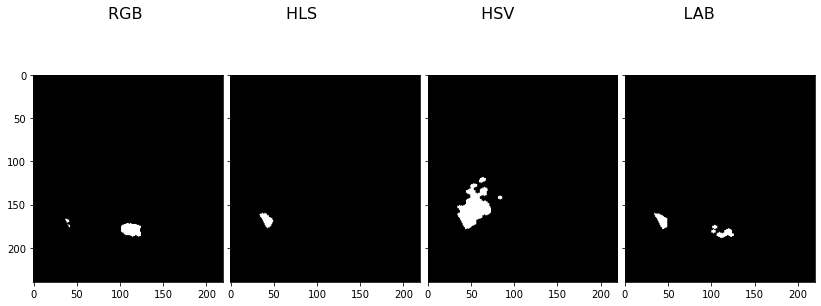

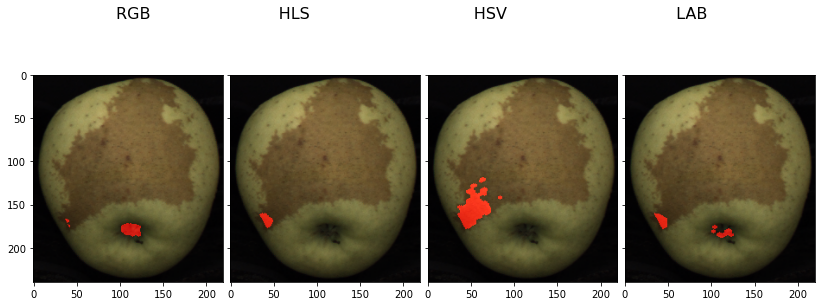

In [18]:
def erodeMask(mask, show_output=False):
    im = mask.copy()
    erosion_size=10
    erosion_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1))
    erosion_dst = cv2.erode(im, erosion_element)

    if show_output:
        plt.imshow(mask,cmap="gray")
        plt.title("Eroded mask")
        plt.show()
    return erosion_dst

eroded_masks = [erodeMask(i) for i in floodFilledImages]

def refine_segmentation(img):
    im = img.copy()
    kernel_size_close=2
    kernel_size_open=2

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_close + 1, 2 * kernel_size_close + 1))
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_open + 1, 2 * kernel_size_open + 1))
    refined = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel_close)
    refined = cv2.morphologyEx(refined, cv2.MORPH_OPEN, kernel_open)

    return refined

## TESTING ON 1ST IMAGE

# Mahalanobis trained on 1st image defects - tesing on 1st image
segmented_color_img_1 = [apply_mahalanobis(original_img=first_sample,
                                           training_img=collage_patches_first_sample,
                                           threshold=param[1], 
                                           color_space=param[0])[0] for param in [["rgb",2],["hls",1.8],["hsv",3],["lab",4]]]

# applying the eroded mask to avoid false positives on borders of the fruit
segmented_color_img_1 = [cv2.bitwise_and(eroded_masks[0],refine_segmentation(segmented_color_img_1[i])) for i in range(len(segmented_color_img_1))]

# plotting results
plot_images_row(segmented_color_img_1, title="RGB                            HLS                                HSV                                 LAB")
overlay_segmented_color_img_1 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[0], dtype=np.uint8)) for i in segmented_color_img_1]

plot_images_row(overlay_segmented_color_img_1, title="RGB                            HLS                                HSV                                 LAB")

## TESTING ON 2ND IMAGE

# Mahalanobis trained on 1st image defects - tesing on 2nd image
segmented_color_img_1 = [apply_mahalanobis(original_img=second_sample, 
                                           training_img=collage_patches_first_sample, 
                                           threshold=param[1], 
                                           color_space=param[0])[0] for param in [["rgb",2],["hls",1.8],["hsv",3],["lab",4]]]

# applying the eroded mask to avoid false positives on borders of the fruit
segmented_color_img_1 = [cv2.bitwise_and(eroded_masks[1],refine_segmentation(segmented_color_img_1[i])) for i in range(len(segmented_color_img_1))]

# plotting results
plot_images_row(segmented_color_img_1, title="RGB                            HLS                                HSV                                 LAB")
overlay_segmented_color_img_1 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[1], dtype=np.uint8)) for i in segmented_color_img_1]
plot_images_row(overlay_segmented_color_img_1, title="RGB                         HLS                                HSV                                 LAB")

Using the patches collected in the first image, the detection of the russet gives the best results using **HLS**: in fact, using it we obtain the russet zones in the first image and just a few points in the second image (that effectively correspond to some zones affected by russet).

#### Mahalanobis trained on the 2nd image patches

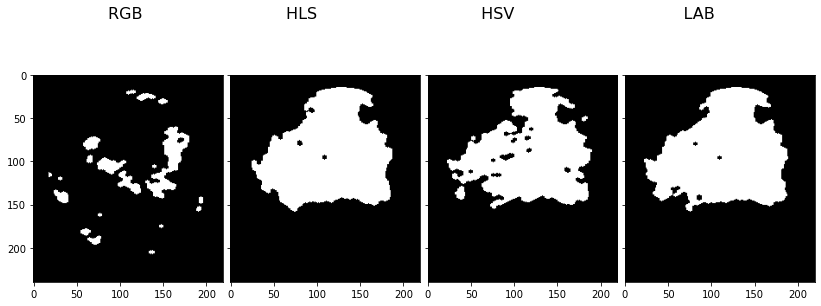

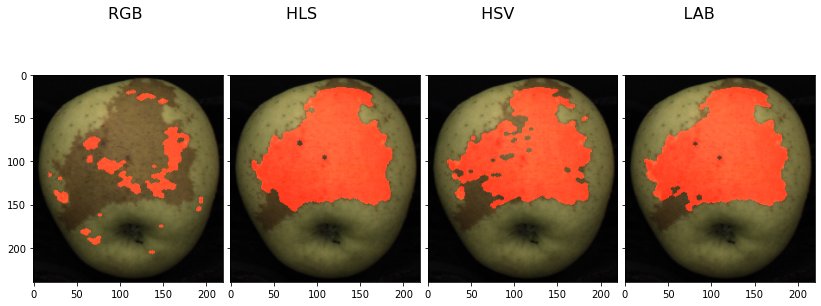

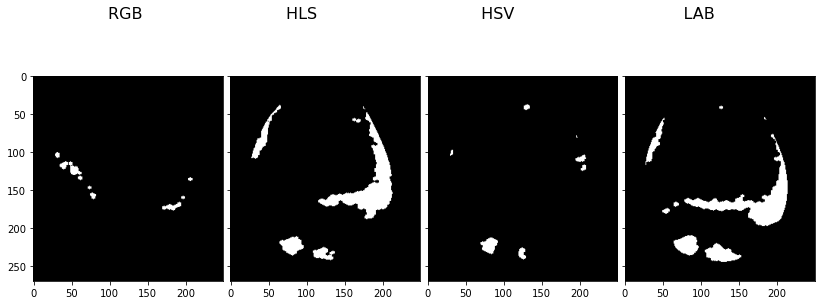

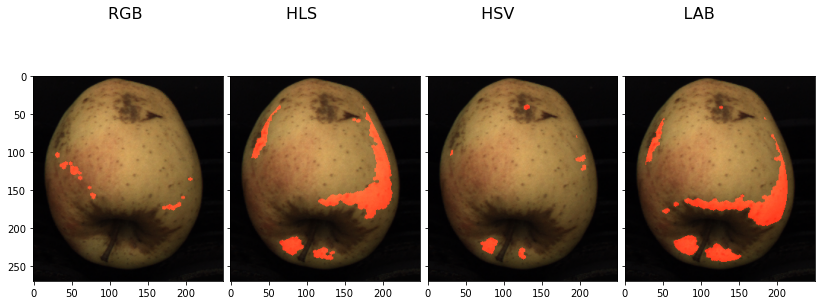

In [19]:
## TESTING ON 2ND IMAGE

def refine_segmentation2(img):
    im = img.copy()
    kernel_size_close=5
    kernel_size_open=2

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_close + 1, 2 * kernel_size_close + 1))
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_open + 1, 2 * kernel_size_open + 1))
    refined = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel_close)
    refined = cv2.morphologyEx(refined, cv2.MORPH_OPEN, kernel_open)
    return refined

# Mahalanobis trained on 2nd image defects - tesing on 2nd image
segmented_color_img_2 = [apply_mahalanobis(original_img=second_sample, 
                                           training_img=collage_patches_second_sample, 
                                           threshold=param[1],
                                           color_space=param[0])[0] for param in [["rgb",2],["hls",2.5],["hsv",5.5],["lab",4]]]

# applying the eroded mask to avoid false positives on borders of the fruit
segmented_color_img_2 = [cv2.bitwise_and(eroded_masks[1],refine_segmentation(segmented_color_img_2[i])) for i in range(len(segmented_color_img_2))]

# plotting results
plot_images_row(segmented_color_img_2, title="RGB                            HLS                                HSV                                 LAB")
overlay_segmented_color_img_2 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[1], dtype=np.uint8)) for i in segmented_color_img_2]
plot_images_row(overlay_segmented_color_img_2, title="RGB                            HLS                                HSV                                 LAB")

## TESTING ON 1ST IMAGE

# Mahalanobis trained on 2nd image defects - tesing on 1st image
segmented_color_img_2 = [apply_mahalanobis(original_img=first_sample, 
                                           training_img=collage_patches_second_sample, 
                                           threshold=param[1], color_space=param[0])[0] for param in [["rgb",2],["hls",2.5],["hsv",5.5],["lab",4]]]

# applying the eroded mask to avoid false positives on borders of the fruit
segmented_color_img_2 = [cv2.bitwise_and(eroded_masks[0],refine_segmentation(segmented_color_img_2[i])) for i in range(len(segmented_color_img_2))]

# plotting results
plot_images_row(segmented_color_img_2, title="RGB                            HLS                                HSV                                 LAB")
overlay_segmented_color_img_2 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[0], dtype=np.uint8)) for i in segmented_color_img_2]
plot_images_row(overlay_segmented_color_img_2, title="RGB                            HLS                                HSV                                 LAB")

In this case, all the color spaces seem getting good results apart from RGB, also, **HSV** results in finding slightly less false positives, so it is the final choice for this phase.

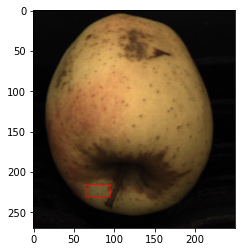

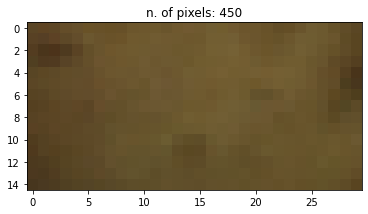

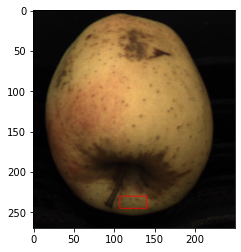

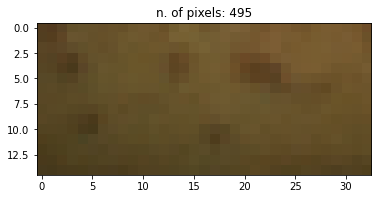

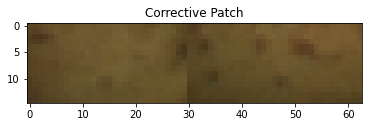

In [20]:
# collecting samples to counteract false positives

first_sample = color_imgs[0].copy()

ROI_corrector_1 = sample_extract(first_sample, 216, 231, 65, 95)
ROI_corrector_2 = sample_extract(first_sample, 230, 245, 107, 140)
#ROI_corrector_3 = np.rot90(sample_extract(first_sample, 90, 184, 190, 205))

# creating the corrective patch

ROI_corrector = np.concatenate((ROI_corrector_1, ROI_corrector_2), axis=1)
plt.imshow(ROI_corrector)
plt.title("Corrective Patch")
plt.show()

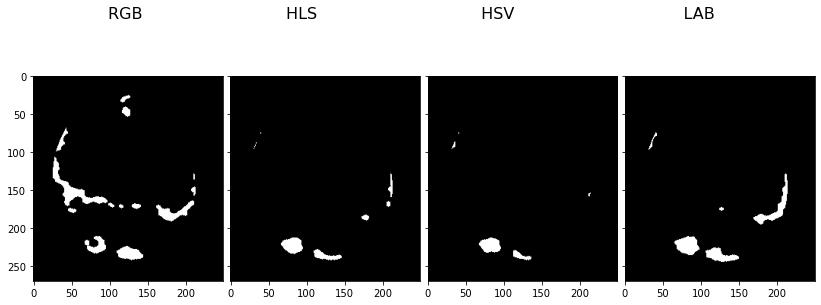

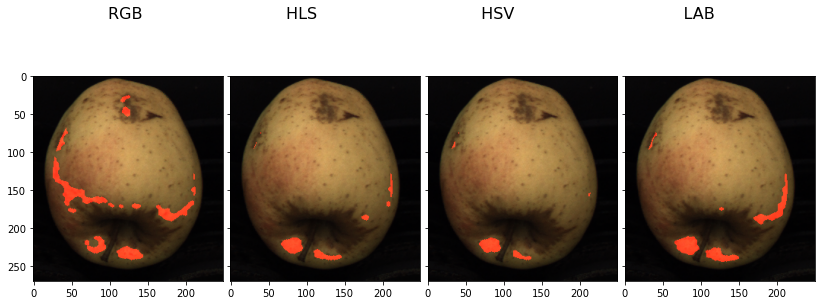

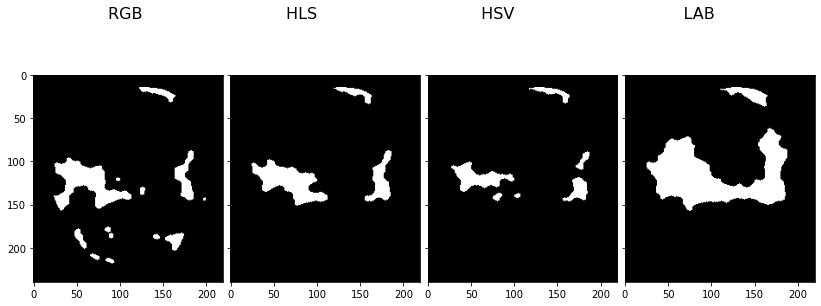

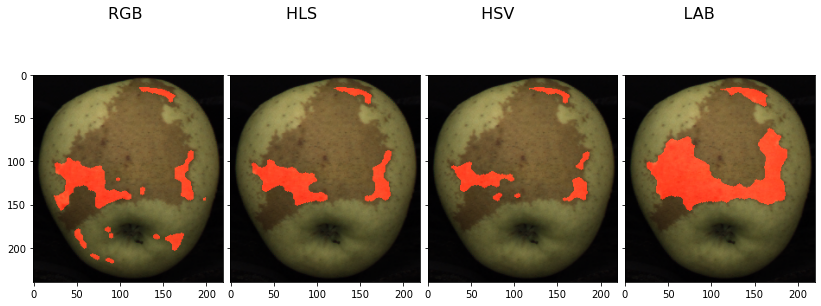

In [21]:
## TESTING ON 1ST IMAGE

# Mahalanobis trained on 2nd image defects - tesing on 1st image
segmented_color_img_2 = [apply_mahalanobis(original_img=first_sample, 
                                           training_img=ROI_corrector, 
                                           threshold=param[1], 
                                           color_space=param[0])[0] for param in [["rgb",2],["hls",1.2],["hsv",0.9],["lab",2]]]

# applying the eroded mask to avoid false positives on borders of the fruit
segmented_color_img_2 = [cv2.bitwise_and(eroded_masks[0],refine_segmentation2(segmented_color_img_2[i])) for i in range(len(segmented_color_img_2))]

# plotting results
plot_images_row(segmented_color_img_2, title="RGB                            HLS                                HSV                                 LAB")
overlay_segmented_color_img_2 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[0], dtype=np.uint8)) for i in segmented_color_img_2]
plot_images_row(overlay_segmented_color_img_2, title="RGB                            HLS                                HSV                                 LAB")

## TESTING ON 2ND IMAGE

# Mahalanobis trained on 2nd image defects - tesing on 2nd image
segmented_color_img_2 = [apply_mahalanobis(original_img=second_sample, 
                                           training_img=ROI_corrector, 
                                           threshold=param[1], 
                                           color_space=param[0])[0] for param in [["rgb",2],["hls",1.2],["hsv",0.9],["lab",2]]]

# applying the eroded mask to avoid false positives on borders of the fruit
segmented_color_img_2 = [cv2.bitwise_and(eroded_masks[1],refine_segmentation2(segmented_color_img_2[i])) for i in range(len(segmented_color_img_2))]

# plotting results
plot_images_row(segmented_color_img_2, title="RGB                            HLS                                HSV                                 LAB")
overlay_segmented_color_img_2 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[1], dtype=np.uint8)) for i in segmented_color_img_2]
plot_images_row(overlay_segmented_color_img_2, title="RGB                            HLS                                HSV                                 LAB")

This corrective color segmentation, using the **HSV** color space, finds quite succesfully the false positives that have to be eliminated: well'subtract these from the previous segmentation (the one obtained with HLS color space). Unfortunately this method has also the cons of detecting also some part of the russet of the second image (but luckily it's just a relatively small part of the whole russet area).

## Building the final pipeline

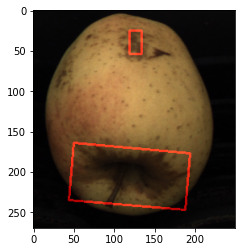

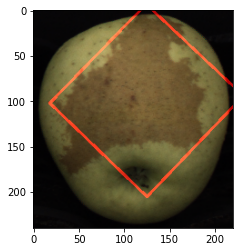

In [22]:
def contourSelectionColor(edge_image, verbose=False, show_output=False):
    # getting connected components following the 8-connected neighbors rule
    contour_list, hierarchy = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_list_clean = []

    for contour in contour_list:
        # computing the area of the contours (including all black pixels inside)
        area = cv2.contourArea(contour)
        # computing the perimeter of the 
        perimeter = cv2.arcLength(contour,True)

        # avoids division by 0 for compactness
        if area > 0:
          compactness = (perimeter**2)/area

        # selection criterias for contoured blobs

        if area>150:
            contour_list_clean.append(contour)
            if verbose:
                print("selected: ",area, perimeter, compactness)
        elif verbose:
            if area>0:
                print("not selected: ",area, perimeter, compactness)
            else:
                print("not selected: ",area, perimeter)

    if show_output:
        img = np.zeros(edge_image.shape)
        cv2.drawContours(img,contour_list_clean,-1,(255,255,255),1)
        plt.imshow(img, cmap="gray")
        plt.title("Selected Contours")
        plt.show()

    return contour_list_clean
def boundingBoxSelectionColor(out_img_shape, contour_list, verbose=False, show_output=False):
    '''
    In this implementation, the contours in input are closed building a convex hull and
    they're filled with white.
    ____________________
    
    out_img_shape:  the dimensions of the mask in which contours have to be displayed
    contour_list:  a list containing the contour
    '''
    img = np.zeros(out_img_shape)
    resulting_rectangles = []
    resulting_contours = []
    for i in range(len(contour_list)):
        rect = cv2.minAreaRect(contour_list[i])
        box = cv2.boxPoints(rect)
        length = rect[1][0]
        width = rect[1][1]
        biggest_side = max(length,width)
        smallest_side = min(length,width)

        if verbose:
            print("big side/small side = ", biggest_side/smallest_side)

        # building bounding boxes
        box = np.int0(box)
        cv2.drawContours(img,[box],-1,(255,255,255),2)
        resulting_rectangles.append(rect)
        resulting_contours.append(contour_list[i])
        
        if show_output:
            plt.imshow(img, cmap="gray")
            plt.title()
            plt.show()

    return img, resulting_rectangles, resulting_contours

def russet_detection(img):
    im = img.copy()

    # converting the original image RGB --> grayscale
    mask = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

    # obtaining mask of the fruit with custom function + OTSU + morph operators
    mask = customFunctionOtsuMorph2(mask,displacement=-23)

    # flood filling the mask
    mask = floodFillBackground(mask)

    # eroding the mask to avoid false positives in proximity of the fruit borders
    mask = erodeMask(mask)

    # computing mahalanobis distance 1
    patch_1 = cv2.cvtColor(collage_patches_first_sample, cv2.COLOR_RGB2HLS)
    variances, means = compute_cov_matrix_and_mean(patch_1)
    mahalanobis_1 = apply_mahalanobis_precomputed(original_img=im, 
                                                  variances=variances, 
                                                  means=means, 
                                                  threshold=1.8, 
                                                  color_space="hls")[0]
    
    # refining the image obtained from the thresholded mahalanobis distance
    mahalanobis_1 = refine_segmentation(mahalanobis_1)

    # removing false positives on the borders using the eroded mask
    mahalanobis_1 = cv2.bitwise_and(mask,mahalanobis_1)

    # computing mahalanobis distance 2
    patch_2 = cv2.cvtColor(collage_patches_second_sample, cv2.COLOR_RGB2HSV)
    variances, means = compute_cov_matrix_and_mean(patch_2)
    mahalanobis_2 = apply_mahalanobis_precomputed(original_img=im, 
                                                  variances=variances, 
                                                  means=means, 
                                                  threshold=5.5, 
                                                  color_space="hsv")[0]
    
    # refining the image obtained from the thresholded mahalanobis distance
    mahalanobis_2 = refine_segmentation(mahalanobis_2)

    # removing false positives on the borders using the eroded mask
    mahalanobis_2 = cv2.bitwise_and(mask,mahalanobis_2)

    # computing corrective patches
    corrective_patch = cv2.cvtColor(ROI_corrector, cv2.COLOR_RGB2HSV)
    variances, means = compute_cov_matrix_and_mean(corrective_patch)
    mahalanobis_correction = apply_mahalanobis_precomputed(original_img=im, 
                                                  variances=variances, 
                                                  means=means, 
                                                  threshold=0.9, 
                                                  color_space="hsv")[0]

    # refining the image obtained from the thresholded mahalanobis distance
    mahalanobis_correction = refine_segmentation2(mahalanobis_correction)

    # removing false positives on the borders using the eroded mask
    mahalanobis_correction = cv2.bitwise_and(mask,mahalanobis_correction)

    # correcting the detected zones of the second images 
    mahalanobis_2 = mahalanobis_2 - cv2.bitwise_and(mahalanobis_correction,mahalanobis_2)

    # summing the detected zones from image 1 and image 2
    mahalanobis = mahalanobis_1 + mahalanobis_2

    # selection based on area and bounding box computation
    contours = contourSelectionColor(mahalanobis)
    final_image = boundingBoxSelectionColor(mahalanobis.shape, contours)[0]

    return np.array(final_image, dtype=np.uint8)

plt.imshow(show_masking_effect(russet_detection(color_imgs[0]), color_imgs[0]))
plt.show()
plt.imshow(show_masking_effect(russet_detection(color_imgs[1]), color_imgs[1]))
plt.show()